# Example: PyRayHF Generate Oblique Data
This is a modification of [`Example_PyRayHF_Cartesian_Gradient.ipynb`](./Example_PyRayHF_Cartesian_Gradient.ipynb) that simply demonstrates the process of ray tracing on input data obtained from PyIRI and generation of the oblique ionogram.

(see [`Example_Generate_2D_Input.ipynb`](./Example_Generate_2D_Input.ipynb) for generating PyIRI input data for PyRayHF)

1. Imports

In [1]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import PyRayHF
from PyRayHF.library import trace_ray_spherical_snells
import time
from copy import deepcopy
import sqlite3
import pandas as pd

2. Load Previously Generated EDP

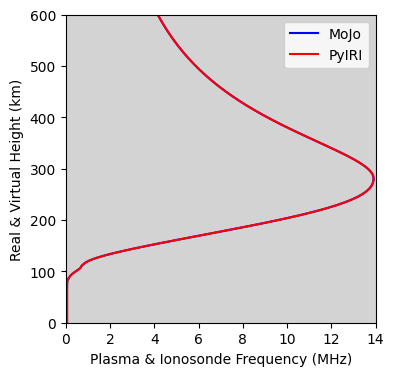

In [12]:
# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create input
# arrays using PyIRI.
file_open = 'MoJo_Data.p'
data = pickle.load(open(file_open, 'rb'))

file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))

R_loc = 1000.

nrays = len(data['ray_data_X'])

af0_Hz = np.zeros(nrays) # Array of ray frequencies
P = np.zeros(nrays)
for i in range(nrays):
    af0_Hz[i] = data["ray_data_X"][i]["freq_Hz"]
    P[i] = data["ray_data_X"][i]["delay_km"]

a_x_apex = np.zeros((nrays))
a_z_apex = np.zeros((nrays))
for i in range(nrays):
    a_x_apex[i] = data['ray_data_X'][i]['x_apex_km']
    a_z_apex[i] = data['ray_data_X'][i]['z_apex_km']

alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_ylim([0, 600])
ax.set_xlim([0, 14])
ax.set_facecolor('lightgray')
ax.set_ylabel('Real & Virtual Height (km)')
ax.set_xlabel('Plasma & Ionosonde Frequency (MHz)')
ax.plot(PyRayHF.library.den2freq(data['edp']) / 1e6,
        data['aalt'], c='blue', label='MoJo', zorder=1)
ax.plot(PyRayHF.library.den2freq(Ne) / 1e6,
        alt_km, c='red', label='PyIRI', zorder=1)
plt.legend()



6. Plot oblique and vertical at midpoint

IndexError: invalid index to scalar variable.

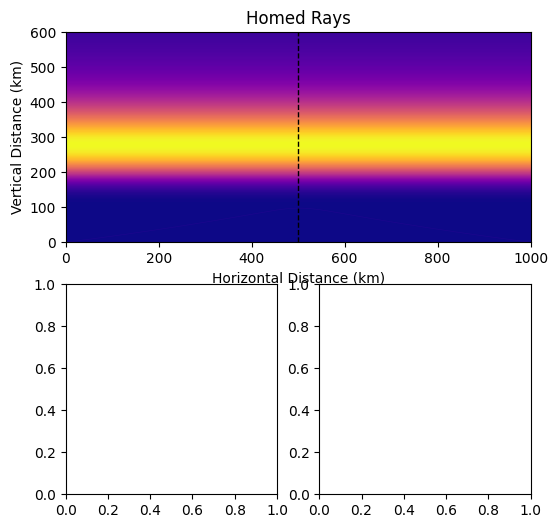

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np

fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
ax_top = fig.add_subplot(gs[0, :])
ax_bot1 = fig.add_subplot(gs[1, 0])
ax_bot2 = fig.add_subplot(gs[1, 1])

# --- Top: Raytracing plot ------------------------------------------------
ax_plot = ax_top
ax_plot.set_xlim(0, 1000)
ax_plot.set_ylim(0, 600)
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Vertical Distance (km)')
ax_plot.set_xlabel('Horizontal Distance (km)')
ax_plot.set_title("Homed Rays")

vmin, vmax = 0, 2.4e12
nx = 500
xmax = 1000.
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
pc = ax_plot.pcolormesh(Xg, Zg, Ne_grid, shading='auto',
                        cmap='plasma', vmin=vmin, vmax=vmax)
ax_plot.axvline(x=R_loc / 2., linestyle='--', color='black', linewidth=1)

cmap = cm.plasma
norm = colors.Normalize(vmin=vmin, vmax=vmax)
af0_den = PyRayHF.library.freq2den(af0_Hz)

for ifr in range(af0_Hz.size):
    color = cmap(norm(af0_den[ifr]))
    ax_plot.plot(data['ray_data_X'][ifr]['x'][:], data['ray_data_X'][ifr]['z'][:], color=color, linewidth=0.5)
ax_plot.text(0.05, 0.95, '(a)', transform=ax_plot.transAxes,
             ha='left', va='top', c='white')

# --- Bottom left: Synthetic Oblique -------------------------------------
ax = ax_bot1
ax.set_title('Synthetic Oblique')
ax.set_facecolor('lightgray')
ax.set_ylabel('Group Path (km)')
ax.set_xlabel('Oblique Frequency (MHz)')
ax.set_xlim([0, 20])
ax.set_ylim([1000, 1600])
f = af0_Hz / 1e6
ax.scatter(f, P, c='black', s=10)
for ifr in range(af0_Hz.size):
    color = cmap(norm(af0_den[ifr]))
    ax.scatter(f[ifr], P[ifr], color=color, s=5)
ax.text(0.05, 0.95, '(b)', transform=ax.transAxes,
        ha='left', va='top', c='black')

# --- Bottom right: Midpoint Vertical ------------------------------------
ax = ax_bot2
ax.set_title('Midpoint Vertical')
ax.set_facecolor('lightgray')
ax.set_ylabel('Virtual Height (km)')
ax.set_xlabel('Vertical Frequency (MHz)')
ax.set_xlim([0, 20])
ax.set_ylim([0, 800])

# Find R_E at the T location
R_E = PyRayHF.library.earth_radius_at_latitude(input_arrays['tlat'])
# Oblique to vertical conversion
freq_vertical_mhz, height_virtual_km = PyRayHF.library.oblique_to_vertical(
    R_loc, P, f, R_E=R_E)

freq_vertical_mhz_den = PyRayHF.library.freq2den(freq_vertical_mhz * 1e6)
ax.scatter(freq_vertical_mhz, height_virtual_km, c='black', s=10)
for ifr in range(af0_Hz.size):
    color = cmap(norm(freq_vertical_mhz_den[ifr]))
    ax.scatter(freq_vertical_mhz[ifr], height_virtual_km[ifr], color=color, s=5)
ax.text(0.05, 0.95, '(c)', transform=ax.transAxes,
        ha='left', va='top', c='black')

# --- Single shared vertical colorbar on the right ------------------------
cbar_ax = fig.add_axes([0.94, 0.59, 0.02, 0.33])  # x, y, width, height
cbar = fig.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.set_label('Electron Density (m$^{-3}$)')
cbar.set_ticks(np.arange(vmin, vmax + 4e11, 4e11))

plt.tight_layout(rect=[0, 0, 0.94, 1])  # leave space for colorbar
plt.savefig('../figures/Oblique.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [4]:
#!/usr/bin/env python
# --------------------------------------------------------
# Distribution Statement A. Approved for public release.
# Distribution is unlimited.
# This work was supported by the Office of Naval Research.
# --------------------------------------------------------
"""Example of a minimization tool in PyRayHF.
"""

import pickle
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import PyRayHF

# Directory on your local machine where to save the figures
local_dir = '/Users/vmakarevich/Documents/GitHub/PyRayHF/docs/figures/'

# Load input arrays from the example.
# See Example_Generate_Input_Arrays for how to create input arrays using PyIRI.
file_open = 'Example_input.p'
input_example = pickle.load(open(file_open, 'rb'))

# Compute virtual height for the ordinary 'O' propagation mode.
# A low number of vertical grid points is sufficient for O-mode (e.g., 200).
# Consider this the model background for the upcoming minimization.
mode = 'X'
n_points = 200

vh_data, EDP_truth = PyRayHF.library.model_VH(input_example['F2'],
                                              input_example['F1'],
                                              input_example['E'],
                                              input_example['freq'],
                                              input_example['alt'],
                                              input_example['bmag'],
                                              input_example['bpsi'],
                                              mode=mode,
                                              n_points=n_points)

# Create a background by modifying the truth parameters:
# increase Nm by 20%, decrease hm by 20%, and increase B_bot by 10%.
# This generates synthetic data. Note that the F1 layer depends on F2
# and will change accordingly.
F2_back = deepcopy(input_example['F2'])
F2_back['Nm'] = F2_back['Nm'] * 1.3
F2_back['hm'] = F2_back['hm'] * 1.2
F2_back['B0'] = F2_back['B0'] * 0.8

# Produce background data, or the observations expected by the background
vh_back, EDP_back = PyRayHF.library.model_VH(F2_back,
                                             input_example['F1'],
                                             input_example['E'],
                                             input_example['freq'],
                                             input_example['alt'],
                                             input_example['bmag'],
                                             input_example['bpsi'],
                                             mode=mode,
                                             n_points=n_points)

# Filter out NaNs in the synthetic data before minimization.
# Minimization will not work properly if NaNs are present.
ind_valid = np.where(np.isfinite(height_virtual_km) == 1)[0]
freq_in = freq_vertical_mhz[ind_valid]  #input_example['freq'][ind_valid]
vh_in = height_virtual_km[ind_valid]

# Using brute-force optimization to find F2-layer parameters that best
# reproduce the synthetic virtual height observations.
# The method searches over a range of values with a 30% perturbation
# margin and step size of 1 km.
(vh_result,
 EDP_result) = PyRayHF.library.minimize_parameters(F2_back,
                                                   input_example['F1'],
                                                   input_example['E'],
                                                   freq_in,
                                                   vh_in,
                                                   input_example['alt'],
                                                   input_example['bmag'],
                                                   input_example['bpsi'],
                                                   method='brute',
                                                   percent_sigma=20.,
                                                   step=1.,
                                                   mode=mode,
                                                   n_points=n_points)

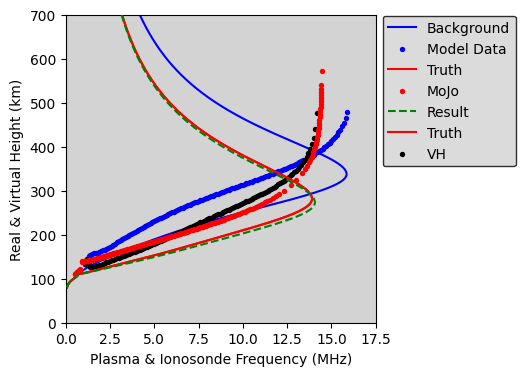

In [5]:
# Plot the results.
# The electron density profile (EDP) is converted from plasma density to plasma
# frequency and plotted using real altitude on the y-axis.
# Virtual heights for O-mode are plotted with ionosonde frequency on
# the x-axis and virtual height on the y-axis.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_ylim([0, 700])
ax.set_xlim([0, 17.5])
ax.set_facecolor('lightgray')
ax.set_ylabel('Real & Virtual Height (km)')
ax.set_xlabel('Plasma & Ionosonde Frequency (MHz)')
ax.plot(PyRayHF.library.den2freq(EDP_back) / 1e6,
        input_example['alt'], c='blue', label='Background', zorder=1)
ax.scatter(input_example['freq'], vh_back, c='blue', label='Model Data',
           zorder=1, linewidth=0, s=15)
ax.plot(PyRayHF.library.den2freq(EDP_truth) / 1e6,
        input_example['alt'], c='red', label='Truth', zorder=2)
ax.scatter(freq_in, vh_in, c='red', label='MoJo',
           zorder=2, linewidth=0, s=15)
ax.plot(PyRayHF.library.den2freq(EDP_result) / 1e6,
        input_example['alt'], '--', c='green', label='Result', zorder=3)
plt.savefig(local_dir + 'Minimization.png', dpi=300, bbox_inches='tight', facecolor='white')

# Load input arrays from the example.
# See Example_Generate_Input_Arrays for how to create input arrays using PyIRI.
file_open = 'Example_input.p'
input_example = pickle.load(open(file_open, 'rb'))

# Compute virtual height for the ordinary 'O' propagation mode.
# A low number of vertical grid points is sufficient for O-mode (e.g., 200).
# Consider this the model background for the upcoming minimization.
mode = 'X'
n_points = 200

# Produce truth, and synthetic observations
vh_data_vert, EDP_truth = PyRayHF.library.model_VH(input_example['F2'],
                                              input_example['F1'],
                                              input_example['E'],
                                              input_example['freq'],
                                              input_example['alt'],
                                              input_example['bmag'],
                                              input_example['bpsi'],
                                              mode=mode,
                                              n_points=n_points)
# Create a known "truth" by modifying the background parameters:
# increase Nm by 20%, decrease hm by 20%, and increase B_bot by 10%.
# This generates synthetic data. Note that the F1 layer depends on F2
# and will change accordingly.

F2_back = deepcopy(input_example['F2'])
F2_back['Nm'] = F2_back['Nm'] * 1.3
F2_back['hm'] = F2_back['hm'] * 1.2
F2_back['B0'] = F2_back['B0'] * 0.8

# Produce background data, or the observations expected by the background
vh_back, EDP_back = PyRayHF.library.model_VH(F2_back,
                                             input_example['F1'],
                                             input_example['E'],
                                             input_example['freq'],
                                             input_example['alt'],
                                             input_example['bmag'],
                                             input_example['bpsi'],
                                             mode=mode,
                                             n_points=n_points)

# Filter out NaNs in the synthetic data before minimization.
# Minimization will not work properly if NaNs are present.
ind_valid = np.where(np.isfinite(vh_data_vert) == 1)[0]
freq_in = input_example['freq'][ind_valid]
ax.plot(PyRayHF.library.den2freq(EDP_truth) / 1e6,
        input_example['alt'], c='red', label='Truth', zorder=2)
ax.scatter(input_example['freq'], vh_data_vert, c='black', label='VH',
           zorder=1, linewidth=0, s=15)

leg = plt.legend(bbox_to_anchor=(1.0, 1.02), facecolor='lightgray', frameon=True)
leg.get_frame().set_edgecolor('black')
